# Analyzing COVID-19 Papers - Phân tích các bài báo về COVID-19

Trong thử thách này, chúng ta sẽ tiếp tục với chủ đề về đại dịch COVID và tập trung vào việc xử lý các bài báo khoa học về chủ đề này.  [Bộ dữ liệu dataset CORD-19](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) với hơn 7000 (tại thời điểm viết bài) bài báo về COVID, có sẵn với siêu dữ liệu và tóm tắt (và đối với khoảng một nửa trong số chúng cũng có toàn văn được cung cấp).

Một ví dụ đầy đủ về việc phân tích tập dữ liệu này bằng cách sử dụng kỹ thuật [Phân tích văn bản cho dịch vụ nhận thức về sức khỏe](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) được mô tả trong bài đăng [trên blog này](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Chúng tôi sẽ thảo luận về phiên bản đơn giản hóa của phân tích này.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Getting the Data - Thu thập dữ liệu

Đầu tiên, chúng ta cần lấy siêu dữ liệu cho các bài báo CORD mà chúng ta sẽ làm việc.

**LƯU Ý:** Chúng tôi không cung cấp bản sao của tập dữ liệu như một phần của kho lưu trữ này. Trước tiên, bạn có thể cần tải xuống
 [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) file from [this dataset on Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Link tải từ Kaggle thường sẽ không đầy đủ các văn bản đầy đủ ngoài tệp siêu dữ liệu. Hoặc truy cập dữ liệu [tại đây](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), bao gồm tất cả các văn bản đầy đủ ngoài tệp siêu dữ liệu.


> **Lưu ý** dữ liệu này khá nặng, khoảng 1 Gb in size, và mất một chút thời giản để load dữ liệu! (~5 mins).
Bạn nên tải xuống dữ liệu nếu bạn có kế hoạch thử nghiệm thêm để tiết kiệm thời gian chờ đợi.

In [ ]:
# Bước 1: Kết nối Google Drive với Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Bước 2: Kiểm tra kết nối
import os

# Kiểm tra thư mục Google Drive đã được gắn kết
os.listdir('/content/drive/MyDrive/Google AI Studio')

['metadata.csv', 'Test tiếng việt', 'bitcoin paper.pdf']

In [ ]:
# Bước 3: Đọc file từ Google Drive (sau khi đã upload file metadata.csv lên Google Drive)
import pandas as pd

# Xây dựng đường dẫn sử dụng ID file
file_id = '1-QhlIGOnkyh1TQUO49Dn2hgFH0TEkNmi'
file_path = f'/content/drive/MyDrive/Google AI Studio/metadata.csv'

# Đọc file CSV từ Google Drive
df = pd.read_csv(file_path, nrows=100000)

# Kiểm tra dữ liệu
df.head()


<ipython-input-55-f1bb10ca4568>:9: DtypeWarning: Columns (1,5,6,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, nrows=100000)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


Bây giờ chúng ta sẽ chuyển đổi cột ngày xuất bản thành `datetime` và vẽ biểu đồ để xem phạm vi ngày xuất bản.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          100000 non-null  object 
 1   sha               58333 non-null   object 
 2   source_x          100000 non-null  object 
 3   title             99911 non-null   object 
 4   doi               100000 non-null  object 
 5   pmcid             79535 non-null   object 
 6   pubmed_id         53589 non-null   object 
 7   license           100000 non-null  object 
 8   abstract          70997 non-null   object 
 9   publish_time      100000 non-null  object 
 10  authors           90188 non-null   object 
 11  journal           95786 non-null   object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  0 non-null       float64
 14  arxiv_id          0 non-null       float64
 15  pdf_json_files    58333 non-null   object 
 16  pmc_json_files    554

Ta thấy, dữ liệu có 19 cột và 1.056.659 dòng, trong đó có các cột quan trọng như: title (tựa đề), abstract (tóm tắt), publish_time (thời gian phát hành), authors (tác giả)...
Các cột (1,4,5,6,13,14,15,16) thì có lẫn lộn, chưa chuẩn hóa.
Do dữ liệu quá lớn nên thời gian xử lý dài, chúng ta thêm định nghĩa lại df chỉ lấy 100.000 dòng đầu tiên bằng tham số: `nrows=100000`

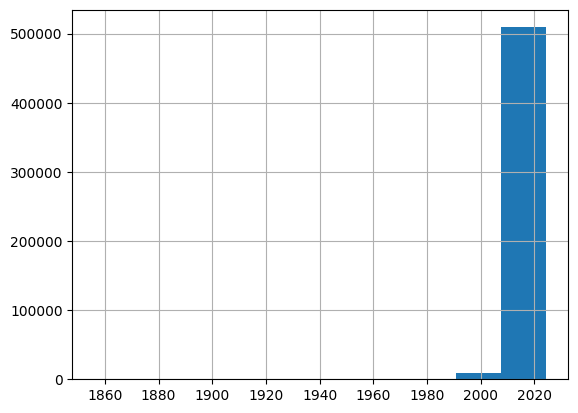

In [ ]:
import pandas as pd
# Chuyển đổi sang datetime, kể cả những dòng không có định dạng datetime
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['publish_time'].hist()
plt.show()

Thật thú vị khi có những bài báo liên quan đến vi-rút corona có từ năm 1880!

## Structured Data Extraction - Trích xuất dữ liệu có cấu trúc

Hãy cùng xem chúng ta có thể dễ dàng trích xuất loại thông tin nào từ các bản tóm tắt. Một điều chúng ta có thể quan tâm là xem có những chiến lược điều trị nào và chúng phát triển như thế nào theo thời gian. Để bắt đầu, chúng ta có thể biên soạn thủ công danh sách các loại thuốc có thể dùng để điều trị COVID và danh sách các chẩn đoán. Sau đó, chúng ta xem xét chúng và tìm kiếm các thuật ngữ tương ứng trong tóm tắt của các bài báo.

In [ ]:
# Liệt kê danh sách các loại thuốc
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin',
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
# Liệt kê các loại bệnh chẩn đoán
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]
# Trích xuất từ cột abstract - tóm tắt
for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Chúng tôi đã thêm một số cột vào khung dữ liệu của mình để chứa số lần một loại thuốc/chẩn đoán nhất định xuất hiện trong bản tóm tắt.

> **Note** rằng chúng ta thêm khoảng trắng vào đầu từ khi tìm kiếm chuỗi con. Nếu chúng ta không làm như vậy, chúng ta có thể nhận được kết quả sai, vì `chloroquine` cũng sẽ được tìm thấy bên trong chuỗi con `hydroxychloroquine`. Ngoài ra, chúng tôi buộc chuyển đổi cột `abstract` thành `str` để loại bỏ lỗi - hãy thử xóa `str` và xem điều gì xảy ra.

Để làm việc với dữ liệu dễ dàng hơn, chúng ta có thể trích xuất khung phụ chỉ với số lượng thuốc và tính toán số lần xuất hiện tích lũy. Điều này cung cấp thuốc phổ biến nhất:

In [ ]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

,Name,Count
0,hydroxychloroquine,11157
3,remdesivir,10680
2,tocilizumab,7914
8,heparin,5563
1,chloroquine,5222
7,dexamethasone,5110
4,azithromycin,4352
5,lopinavir,4315
9,favipiravir,3358
10,methylprednisolone,2346


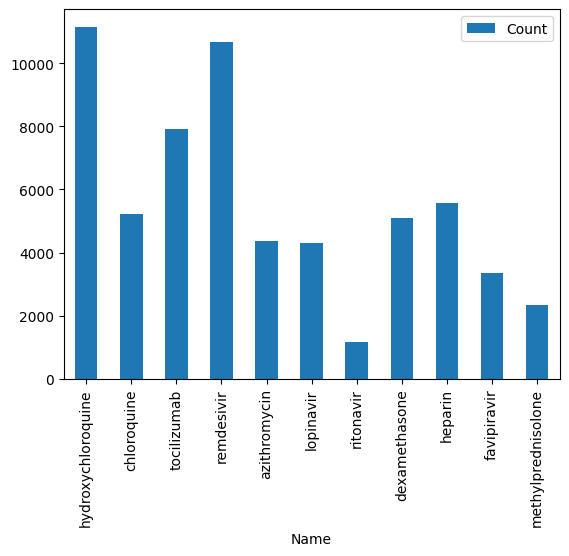

In [ ]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Looking for Trends in Treatment Strategy

In the example above we have `sum`ed all values, but we can also do the same on a monthly basis:

In [ ]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                              2            0            0   
             2                              0           19            0   
             3                             46           73            5   
             4                            186          236           49   
             5                            450          188          158   
             6                            381          149          243   
             7                            379          176          204   
             8                            313          115          175   
             9                            318          124          188   
             10                           311           96          210   
             11                           267           66          169   
             12                           254          108          228   
2021         1                            212           81          145   
             2                            165           66          184   
             3                            175           86          189   
             4                            200           71          129   
             5                            152           55          139   
             6                            144           30          146   
             7                            115           45           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                      6             3          6          1   
             2                      3             3         18         11   
             3                     29            12         52         16   
             4                    122            69        113         13   
             5                    209           128        134         41   
             6                    186           110        132         18   
             7                    174           108        138         29   
             8                    173           148         93         24   
             9                    190            90         97         28   
             10                   227            93        126         39   
             11                   202            77        106         27   
             12                   267            98         75         30   
2021         1                    186            67         67         19   
             2                    180            90         76          9   
             3                    301            89        101         18   
             4                    167            89         60         13   
             5                    182            71         56         22   
             6                    180            75         47         14   
             7                    252            83         52          4   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                         0        6            0   
             2                         1        3           12   
             3                         3       18           11   
             4                        14       80           48   
             5                        12       93           48   
             6                        48       84           30   
             7                        58      116           56   
             8                        56       96           46   
             9                        90      113           46   
             10                      101      117           82   
             11                       84 

This gives us a good picture of treatment strategies. Let's visualize it!

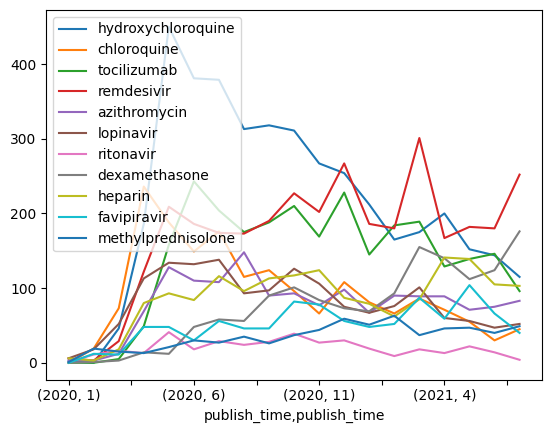

In [ ]:
dfmt.plot()
plt.show()

An interesting observation is that we have huge spikes at two locations: January, 2020 and January, 2021. It is caused by the fact that some papers do not have a clearly specified data of publication, and they are specified as January of the respective year.

To make more sense of the data, let's visualize just a few medicines. We will also "erase" data for January, and fill it in by some medium value, in order to make nicer plot:

<ipython-input-16-4dec8ab5a790>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfmt.fillna(method='pad',inplace=True)


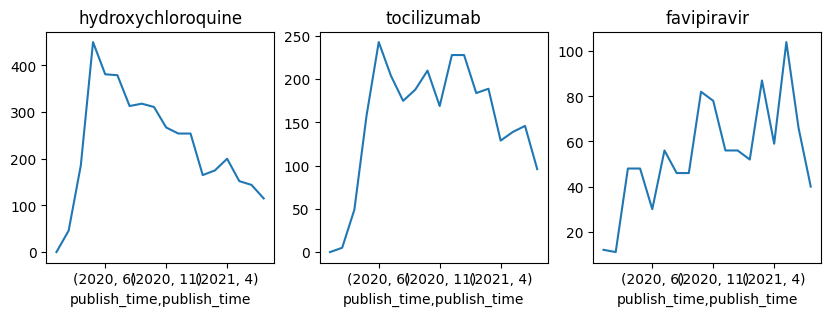

In [ ]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

Observe how popularity of hydroxychloroquine was on the rise in the first few months, and then started to decline, while number of mentions of favipiravir shows stable rise. Another good way to visualize relative popularity is to use **stack plot** (or **area plot** in Pandas terminology):

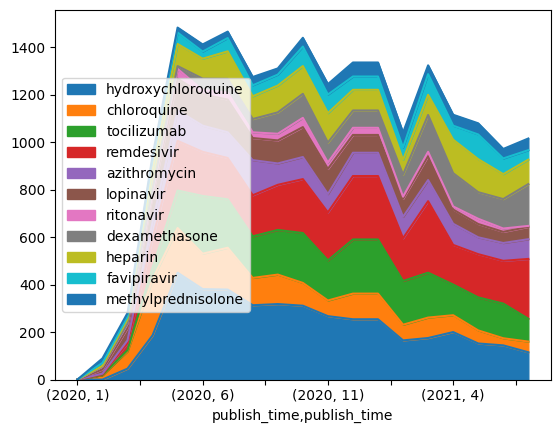

In [ ]:
dfmt.plot.area()
plt.show()

Even further, we can compute relative popularity in percents:

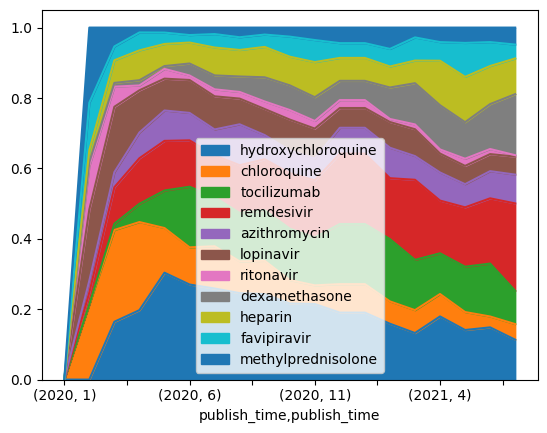

In [ ]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()


## Computing Medicine-Diagnosis Correspondence

One of the most interesting relationships we can look for is how different diagnoses are treated with different medicines. In order to visualize it, we need to compute **co-occurence frequency map**, which would show how many times two terms are mentioned in the same paper.

Such a map is essentially a 2D matrix, which is best represented by **numpy array**. We will compute this map by walking through all abstracts, and marking entities that occur there:

In [ ]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [ ]:
m

array([[5470., 2585.,  812., 2381.,  387., 3036., 1081.],
       [2376., 1381.,  258., 1077.,   90., 1555.,  408.],
       [2738., 1007.,  833., 1343.,  236., 1333.,  678.],
       [4284., 2804.,  720., 2076.,  241., 2677.,  817.],
       [2163.,  928.,  476., 1066.,  180., 1032.,  481.],
       [2244., 1239.,  424.,  976.,  122., 1495.,  406.],
       [ 594.,  429.,   87.,  301.,   23.,  409.,  123.],
       [2164.,  919.,  521., 1113.,  180., 1019.,  463.],
       [2035.,  877.,  428.,  999.,  137.,  996.,  365.],
       [1257.,  791.,  250.,  565.,   55.,  804.,  173.],
       [1008.,  476.,  399.,  574.,  100.,  582.,  205.]])

One of the ways to visualize this matrix is to draw a **heatmap**:

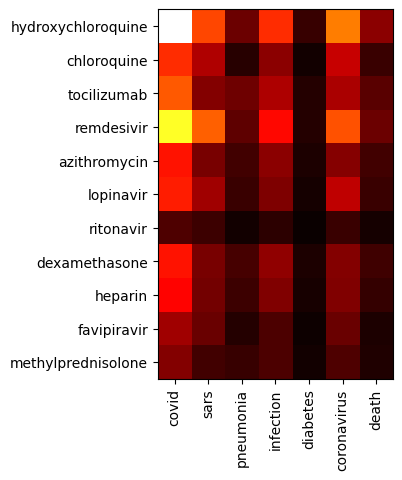

In [ ]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications)))
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

However, even better visualization can be done using so-called **Sankey** diagram! `matplotlib` does not have built-in support for this diagram type, so we would have to use [Plotly](https://plotly.com/python/) as described [in this tutorial](https://plotly.com/python/sankey-diagram/).

To make plotly sankey diagram, we need to build the following lists:
* List `all_nodes` of all nodes in the graph, which will include both medications and diagnosis
* List of source and target indices - those lists would show, which nodes go to the left, and which to the right part of the diagram
* List of all links, each link consisting of:
   - Source index in the `all_nodes` array
   - Target index
   - Value indicating strength of the link. This is exactly the value from our co-occurence matrix.
   - Optionally color of the link. We will make an option to highlight some of the terms for clarity

Generic code to draw sankey diagram is structured as a separate `sankey` function, which takes two lists (source and target categories) and co-occurence matrix. It also allows us to specify the threshold, and omit all links that are weaker than that threshold - this makes the diagram a little bit less complex.

In [ ]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Conclusion

Bạn đã thấy rằng chúng ta có thể sử dụng các phương pháp khá đơn giản để trích xuất thông tin từ các nguồn dữ liệu không có cấu trúc, chẳng hạn như văn bản. Trong ví dụ này, chúng tôi đã lấy danh sách thuốc hiện có, nhưng sẽ mạnh hơn nhiều nếu sử dụng các kỹ thuật xử lý ngôn ngữ tự nhiên (NLP) để thực hiện trích xuất thực thể từ văn bản. Trong [blog post này](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) chúng tôi mô tả cách sử dụng dịch vụ đám mây để trích xuất thực thể. Một lựa chọn khác là sử dụng các thư viện NLP của Python như [NLTK](https://www.nltk.org/) - một cách tiếp cận để trích xuất thông tin từ văn bản bằng cách sử dụng NLTK được mô tả [ở đây](https://www.nltk.org/book/ch07.html).

## Challenge

Tiếp tục nghiên cứu dữ liệu bài báo về COVID theo các hướng sau:

1. Xây dựng **ma trận đồng xuất hiện** (co-occurence) của các loại thuốc khác nhau và xem loại thuốc nào thường xuất hiện cùng nhau (tức là cùng được đề cập trong một bản tóm tắt). Bạn có thể viết lệnh Code để xây dựng ma trận đồng xuất hiện cho cặp **thuốc & chẩn đoán**.
2. Hãy trực quan hóa sự xuất hiện đồng thời của các loại thuốc bằng biểu đồ [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram). [Thư viện này](https://pypi.org/project/chord/) có thể giúp bạn.
3. Hãy trích xuất liều lượng của các loại thuốc khác nhau (chẳng hạn như **400mg** trong liều dùng 400mg chloroquine mỗi ngày) bằng cách sử dụng biểu thức chính quy và xây dựng dataframe hiển thị **liều lượng khác nhau** cho các loại thuốc khác nhau. **Note**: liều dùng là các giá trị số nằm gần với tên thuốc.

## Challenge 1: Xây dựng ma trận co-occurence

In [ ]:
# Bước 1: Tiền xử lý dữ liệu
import re
from collections import Counter
# Liệt kê thủ công các loại thuốc
drugs_list = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin',
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
# Liệt kê các loại bệnh chẩn đoán
diagnoses_list = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death']

# Định nghĩa hàm làm sạch và tách từ
def clean_and_tokenize(text):
    if isinstance(text, str):
        text = text.lower()  # Chuyển thành chữ thường
        text = re.sub(r'[^a-z\s]', '', text)  # Loại bỏ dấu câu và ký tự không phải chữ
        return text.split()
    else:
        return []

# Tạo danh sách cho tokens (sẽ chứa tất cả tokens từ mọi phần)
all_tokens = []

In [ ]:
# Áp dụng hàm lên cột 'abstract' (hoặc bất kỳ cột nào bạn cần)
df['tokens'] = df['abstract'].apply(clean_and_tokenize)

# Kiểm tra dữ liệu đã làm sạch
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,tokens
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"[objective, this, retrospective, chart, review..."
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[inflammatory, diseases, of, the, respiratory,..."
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[surfactant, proteind, spd, participates, in, ..."
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[endothelin, et, is, a, amino, acid, peptide, ..."
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[respiratory, syncytial, virus, rsv, and, pneu..."


In [ ]:
# Bước 2: Xây dựng ma trận co-occurence
import numpy as np

# Khởi tạo ma trận đồng xuất hiện (co-occurrence matrix)
cooccurrence_matrix = pd.DataFrame(np.zeros((len(drugs_list), len(diagnoses_list))),
                                    index=drugs_list, columns=diagnoses_list)

# Duyệt qua từng hàng trong DataFrame
for i, row in df.iterrows():
    # Lấy các từ khóa thuốc và chẩn đoán xuất hiện trong abstract
    drugs_in_abstract = [drug for drug in drugs_list if drug in row['tokens']]
    diagnoses_in_abstract = [diagnosis for diagnosis in diagnoses_list if diagnosis in row['tokens']]

    # Cập nhật ma trận đồng xuất hiện
    for drug in drugs_in_abstract:
        for diagnosis in diagnoses_in_abstract:
            cooccurrence_matrix.at[drug, diagnosis] += 1

# Kiểm tra kết quả
print(cooccurrence_matrix)

                    covid  sars  pneumonia  infection  diabetes  coronavirus  \
hydroxychloroquine   91.0   4.0       16.0       42.0      11.0         50.0   
chloroquine          47.0   2.0        7.0       29.0       0.0         34.0   
tocilizumab          46.0   1.0       13.0       25.0       8.0         18.0   
remdesivir           87.0   5.0       18.0       39.0       8.0         57.0   
azithromycin         38.0   2.0       20.0       35.0       9.0         19.0   
lopinavir            10.0   2.0        0.0        3.0       1.0          9.0   
ritonavir             7.0   1.0        1.0        4.0       1.0          7.0   
dexamethasone        37.0   1.0       13.0       30.0      12.0         16.0   
heparin              39.0   0.0       10.0       24.0       7.0         22.0   
favipiravir          23.0   2.0        1.0       16.0       0.0         17.0   
methylprednisolone   24.0   1.0       18.0       23.0       6.0         14.0   

                    death  
hydroxychlo

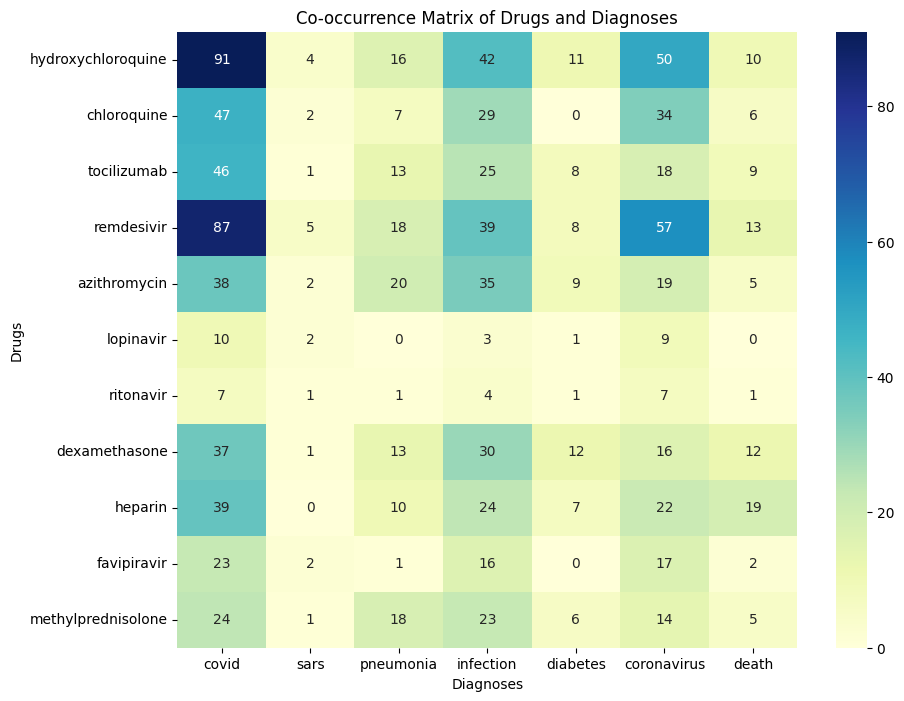

In [ ]:
# Bước 3: Trực quan hóa
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ heatmap của ma trận đồng xuất hiện
plt.figure(figsize=(10, 8))
sns.heatmap(cooccurrence_matrix, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Co-occurrence Matrix of Drugs and Diagnoses')
plt.xlabel('Diagnoses')
plt.ylabel('Drugs')
plt.show()


## Challenge 2: Trực quan hóa sự xuất hiện đồng thời của các loại thuốc bằng biểu đồ Chord diagram

In [ ]:
# Bước 1: Tiền xử lý dữ liệu
import re
from collections import Counter
drugs_list = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin',
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
# Liệt kê các loại bệnh chẩn đoán
diagnoses_list = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death']


In [ ]:
# Bước 2: Xử lý dữ liệu - Bỏ qua các dòng có giá trị NaN trong cột 'abstract'
df = df[df['abstract'].notna()]


In [ ]:
# Bước 2: Hàm làm sạch và tách từ (bao gồm việc chuyển về chữ thường)
def clean_and_tokenize(text):
    if isinstance(text, str):
        text = text.lower()  # Chuyển thành chữ thường
        text = re.sub(r'[^a-z\s]', '', text)  # Loại bỏ dấu câu và ký tự không phải chữ
        return text.split()
    else:
        return []

# Áp dụng hàm làm sạch và tách từ cho cột 'abstract'
df['tokens'] = df['abstract'].apply(clean_and_tokenize)

# Kiểm tra kết quả
print(df['tokens'].head())


0    [objective, this, retrospective, chart, review...
1    [inflammatory, diseases, of, the, respiratory,...
2    [surfactant, proteind, spd, participates, in, ...
3    [endothelin, et, is, a, amino, acid, peptide, ...
4    [respiratory, syncytial, virus, rsv, and, pneu...
Name: tokens, dtype: object


In [ ]:
# Bước 3: Khởi tạo ma trận đồng xuất hiện (co-occurrence matrix) với giá trị mặc định là 0
cooccurrence_matrix = pd.DataFrame(np.zeros((len(drugs_list), len(drugs_list))),
                                    index=drugs_list, columns=drugs_list)

# Duyệt qua từng hàng trong DataFrame
for i, row in df.iterrows():
    # Tìm các thuốc xuất hiện trong abstract (chuẩn hóa tên thuốc trước)
    drugs_in_abstract = [drug for drug in drugs_list if drug in row['tokens']]

    # Cập nhật ma trận đồng xuất hiện
    for i in range(len(drugs_in_abstract)):
        for j in range(i + 1, len(drugs_in_abstract)):
            drug1 = drugs_in_abstract[i]
            drug2 = drugs_in_abstract[j]
            cooccurrence_matrix.at[drug1, drug2] += 1
            cooccurrence_matrix.at[drug2, drug1] += 1

# Kiểm tra ma trận đồng xuất hiện
print(cooccurrence_matrix)


                    hydroxychloroquine  chloroquine  tocilizumab  remdesivir  \
hydroxychloroquine                 0.0         27.0         10.0        29.0   
chloroquine                       27.0          0.0          0.0        12.0   
tocilizumab                       10.0          0.0          0.0        13.0   
remdesivir                        29.0         12.0         13.0         0.0   
azithromycin                      22.0          6.0          5.0         6.0   
lopinavir                          3.0          2.0          1.0         5.0   
ritonavir                          3.0          1.0          0.0         4.0   
dexamethasone                      5.0          0.0          5.0        10.0   
heparin                            4.0          1.0          0.0         2.0   
favipiravir                        8.0          8.0          1.0        17.0   
methylprednisolone                 6.0          0.0          3.0         5.0   

                    azithromycin  lopin

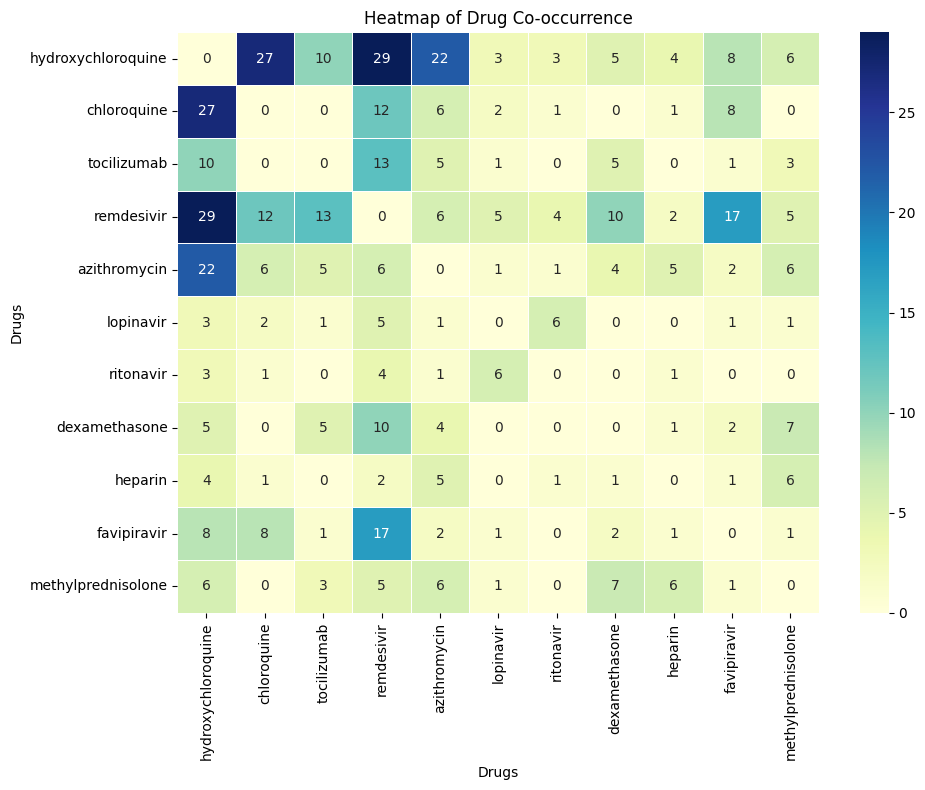

In [ ]:
# Bước 4: Trực quan hóa
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ heatmap cho ma trận đồng xuất hiện
plt.figure(figsize=(10, 8))  # Điều chỉnh kích thước biểu đồ cho phù hợp

# Vẽ heatmap sử dụng seaborn
sns.heatmap(cooccurrence_matrix, annot=True, cmap='YlGnBu', fmt='g', linewidths=0.5)

# Tiêu đề và nhãn
plt.title('Heatmap of Drug Co-occurrence')
plt.xlabel('Drugs')
plt.ylabel('Drugs')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


## Chalenge 3: Hãy trích xuất liều lượng của các loại thuốc khác nhau

Bằng cách sử dụng biểu thức chính quy và xây dựng dataframe hiển thị liều lượng khác nhau cho các loại thuốc khác nhau. **Ví dụ:** liều dùng 400mg chloroquine mỗi ngày.

**Note:** liều dùng là các giá trị số nằm gần với tên thuốc, có thể nằm trước hoặc sau trong cột Abstract, ví dụ như "20mg of dexamethasone" hoặc "used with 100mg of hydroxychloroquine".

Biểu thức chính quy phù hợp (regex) để trích xuất liều lượng (dosage):

`\b(\d+(?:\.\d+)?(?:\s?(?:mg|g|ml|mcg|µg|units|IU|tablet|capsule|dose|drops|pills|injections|vials|mg/kg)))\b`


Giải thích biểu thức regex:
* \b: Ranh giới từ (đảm bảo khớp chính xác với từ có nghĩa, không phải là chuỗi con của từ khác).
* (\d+(?:\.\d+)?): Khớp một hoặc nhiều chữ số, có thể bao gồm phần thập phân.
\d+: Ít nhất một chữ số.
* (?:\.\d+)?: Phần thập phân tùy chọn.
* \s?: Có hoặc không có khoảng trắng giữa số và đơn vị.
* (?:mg|g|ml|mcg|µg|units|IU): Các đơn vị thường gặp trong liều lượng thuốc.
* \b: Kết thúc ranh giới từ.

Biểu thức để trích xuất tên thuốc:
`\b(?:\d+\s*mg\s*of\s*)?([A-Za-z0-9-]+(?:\s[A-Za-z0-9-]+)*)\b`

Giải thích cải tiến:

* Cho phép các cụm từ như 50 mg of drugname.
* Cho phép các tên thuốc phức tạp với dấu - và số (azithromycin-500).

In [ ]:
import pandas as pd
import re

# Danh sách thuốc cần trích xuất
drugs_list = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin',
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone'
]
# Regex liều lượng:
dosage_pattern = r'\b(\d+(?:\.\d+)?(?:\s?(?:mg|g|ml|mcg|µg|units|IU|tablet|capsule|dose|drops|pills|injections|vials|mg/kg)))\b'
# Regex tên thuốc:
drugs_pattern = r'\b(' + '|'.join(re.escape(drug) for drug in drugs_list) + r')\b'

# 1. Làm sạch cột abstract (loại bỏ NaN)
df = df.dropna(subset=['abstract']).reset_index(drop=True)

# 2. Trích xuất dosage (liều lượng)
df['dosage'] = df['abstract'].str.extract(dosage_pattern)

# 3. Trích xuất drug (tên thuốc)
df['drug'] = df['abstract'].str.extract(drugs_pattern)

# 4. Lọc các dòng có thông tin dosage và drug
df_filtered = df.dropna(subset=['dosage', 'drug'])[['abstract', 'dosage', 'drug']]

# Hiển thị bảng kết quả
from IPython.display import display
print("🔍 **Kết quả các dòng đã trích xuất được (abstract, dosage, drug):**")
display(df_filtered)


🔍 **Kết quả các dòng đã trích xuất được (abstract, dosage, drug):**


,abstract,dosage,drug
260,INTRODUCTION: Autoimmune hemolytic anemia in c...,375 mg,methylprednisolone
312,INTRODUCTION: Macrophage activating syndrome i...,150 mg,dexamethasone
2938,The hydroalcoholic extract of Punica granatum ...,300 mg,dexamethasone
3437,Chloroquine diphosphate (CQ) is a hydrophilic ...,20 µg,chloroquine
3685,Liver failure with hemophagocytic lymphohistio...,1.5 mg,methylprednisolone
...,...,...,...
68104,We describe the case of a coronavirus disease ...,100 IU,heparin
68497,"Within the COVID-19 pandemic context, the WHO ...",000 mg,chloroquine
69334,This study was planned to evaluate the prevent...,0.2 mg,dexamethasone
70132,ETHNOPHARMACOLOGICAL RELEVANCE Inflammatory sk...,35g,dexamethasone


In [ ]:
# Lọc các dòng không có dosage hoặc drug
df_missing = df[(df['dosage'].isna()) | (df['drug'].isna())]

# Hiển thị các dòng không trích xuất được
from IPython.display import display
display(df_missing['abstract'])


,abstract
0,OBJECTIVE: This retrospective chart review des...
1,Inflammatory diseases of the respiratory tract...
2,Surfactant protein-D (SP-D) participates in th...
3,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,Respiratory syncytial virus (RSV) and pneumoni...
...,...
70992,Current standard of care for full-thickness bu...
70993,"Forty-four specific pathogen-free beagles, med..."
70994,AIM To obtain an overview of existing evidence...
70995,INTRODUCTION/AIMS It is unclear whether the he...


Đối với dữ liệu lớn thì đây vẫn chưa phải cách hiệu quả.
Một số cách tiếp cận khác:

* 1. Xử lý Dữ liệu theo Lô (Batch Processing)
Thay vì đọc toàn bộ dữ liệu vào bộ nhớ, bạn có thể đọc và xử lý từng phần dữ liệu nhỏ bằng cách sử dụng chunksize khi đọc file CSV.

* 2. Sử dụng Dask cho Dữ liệu Siêu Lớn
Nếu dữ liệu của bạn quá lớn để xử lý với Pandas, bạn có thể sử dụng Dask. Dask là một thư viện tương thích với Pandas nhưng hỗ trợ xử lý song song.

* 3. Sử dụng Mô Hình Học Máy (Machine Learning)

Dùng mô hình NER (Named Entity Recognition) từ thư viện spaCy hoặc HuggingFace Transformers để phát hiện liều lượng và thuốc.
Ví dụ: en_core_med7_trf (mô hình cho y khoa của spaCy).